In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
# Add the fourier_learning_ibm package to the path
import sys, pprint

sys.path.append("/home/jovyan/fourier_learning_ibm/")
pprint.pprint(sys.path)

['/home/jovyan',
 '/opt/conda/lib/python311.zip',
 '/opt/conda/lib/python3.11',
 '/opt/conda/lib/python3.11/lib-dynload',
 '',
 '/opt/conda/lib/python3.11/site-packages',
 '/home/jovyan/fourier_learning_ibm/']


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from qiskit_ibm_runtime import (
    QiskitRuntimeService,
    SamplerV2 as Sampler,
    Batch,
)
from heisenberg import (
    HeisenbergModel,
    get_graph,
    get_positions,
    get_initial_layout,
    get_prob0,
)
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel

In [4]:
n_qubits = 4

# total time to be simulated
# type is list so that it can be saved to json
total_time = 15
times = np.linspace(0, total_time, total_time * 2 + 1).tolist()  # 2 points per second

rng = np.random.default_rng(42)

## Create graph (Demo)

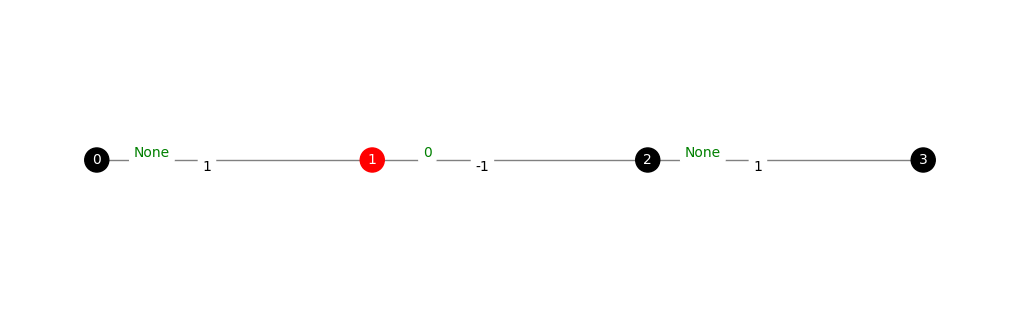

In [5]:
G = get_graph(n_qubits, rng)

# エッジの重みを上書き
for edge in G.edges:
    # 1 と -1 を交互に設定
    if edge[0] % 2 == 0:
        G.edges[edge]["J"] = 1
    else:
        G.edges[edge]["J"] = -1

positions = get_positions(n_qubits)

# エッジラベルを作成
edge_J_labels = {edge: f"{G.edges[edge]['J']:.2g}" for edge in G.edges}
edge_cnot_order_labels = {edge: f"{G.edges[edge]['cnot']['order']}" for edge in G.edges}

# グラフを描画
plt.figure(figsize=(10, 3))
nx.draw(
    G,
    pos=positions,
    with_labels=True,
    node_color=["red" if G.nodes[node]["hadamard"] else "black" for node in G.nodes],
    node_size=300,
    edge_color="gray",
    font_color="white",
    font_size=10,
)

# エッジの重みを描画
nx.draw_networkx_edge_labels(
    G,
    pos=positions,
    edge_labels=edge_J_labels,
    font_size=10,
    font_color="black",
    label_pos=0.6,
    verticalalignment="top",
)

# エッジの 'cnot' 'order' 属性を描画
nx.draw_networkx_edge_labels(
    G,
    pos=positions,
    edge_labels=edge_cnot_order_labels,
    font_size=10,
    font_color="green",
    label_pos=0.8,
    verticalalignment="bottom",
)

plt.show()

In [6]:
# Option1: Use IBM Quantum backend.
# Set up the Qiskit Runtime service (this is a one-time setup)
# QiskitRuntimeService.save_account(
#     token="YOUR_API_TOKEN",
#     channel="ibm_quantum",
# )

# Load saved credentials
service = QiskitRuntimeService()
# backend_qpu = service.least_busy(simulator=False, interactional=True)
backend_qpu = service.backend("ibm_marrakesh")

# Option2: Use local AerSimulator as the backend.
backend_sim = AerSimulator()
noise_model = NoiseModel.from_backend(backend_qpu)
backend_sim_noisy = AerSimulator(noise_model=noise_model)

print(f"Using backend QPU: {backend_qpu}")
print(f"Using backend simulator: {backend_sim}")
print(f"Using backend noisy simulator: {backend_sim_noisy}")

Using backend QPU: <IBMBackend('ibm_marrakesh')>
Using backend simulator: AerSimulator('aer_simulator')
Using backend noisy simulator: AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['cz', 'x', 'reset', 'sx', 'measure', 'id']>)


In [7]:
rng = np.random.default_rng(42)
n_steps_range = np.arange(1, 6)

In [8]:
# Only for CP1
%cd fourier_learning_ibm/

/home/jovyan/fourier_learning_ibm


In [9]:
# Create a Heisenberg model
heisenberg = HeisenbergModel(n_qubits, G, backend_sim_noisy)

### Non Trotter simulation (exact)

In [10]:
# Result strage
prob0s_exact = [heisenberg.exact_simulation(t, phase=0) for t in times]

/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/opt/conda/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


### Trotter simulation (noisy)

In [ ]:
# Create circuits
circuits = {}
exec_circuits = {}

In [11]:
# Result strage
prob0s_of_all_n_steps: dict[int, list[float]] = {
    # dict[int, list[float]]:
    #     int: n_steps
    #     list[float]: prob0s
}

for n_steps in n_steps_range:
    print(f"n_steps: {n_steps}")
    prob0s = []

    for k in range(len(times)):
        print(f"k: {k}, time: {times[k]:.3f}")
        circuit, exec_circuit = heisenberg.get_trotter_simulation_circuit(
            times[k], n_steps, phase=0
        )

        # Execute the circuit
        sampler = Sampler(backend_sim_noisy)
        job = sampler.run([exec_circuit])
        result = job.result()

        meas_counts = result[0].data.meas.get_counts()
        num_shots = result[0].data.meas.num_shots
        zero_counts = meas_counts.get("0" * n_qubits, 0)
        prob0 = zero_counts / num_shots
        prob0s.append(prob0)
    print()

    prob0s_of_all_n_steps[n_steps] = prob0s

n_steps: 1
k: 0, time: 0.000
k: 1, time: 0.500
k: 2, time: 1.000
k: 3, time: 1.500
k: 4, time: 2.000
k: 5, time: 2.500
k: 6, time: 3.000
k: 7, time: 3.500
k: 8, time: 4.000
k: 9, time: 4.500
k: 10, time: 5.000
k: 11, time: 5.500
k: 12, time: 6.000
k: 13, time: 6.500
k: 14, time: 7.000
k: 15, time: 7.500
k: 16, time: 8.000
k: 17, time: 8.500
k: 18, time: 9.000
k: 19, time: 9.500
k: 20, time: 10.000
k: 21, time: 10.500
k: 22, time: 11.000
k: 23, time: 11.500
k: 24, time: 12.000
k: 25, time: 12.500
k: 26, time: 13.000
k: 27, time: 13.500
k: 28, time: 14.000
k: 29, time: 14.500
k: 30, time: 15.000

n_steps: 2
k: 0, time: 0.000
k: 1, time: 0.500
k: 2, time: 1.000
k: 3, time: 1.500
k: 4, time: 2.000
k: 5, time: 2.500
k: 6, time: 3.000
k: 7, time: 3.500
k: 8, time: 4.000
k: 9, time: 4.500
k: 10, time: 5.000
k: 11, time: 5.500
k: 12, time: 6.000
k: 13, time: 6.500
k: 14, time: 7.000
k: 15, time: 7.500
k: 16, time: 8.000
k: 17, time: 8.500
k: 18, time: 9.000
k: 19, time: 9.500
k: 20, time: 10.0

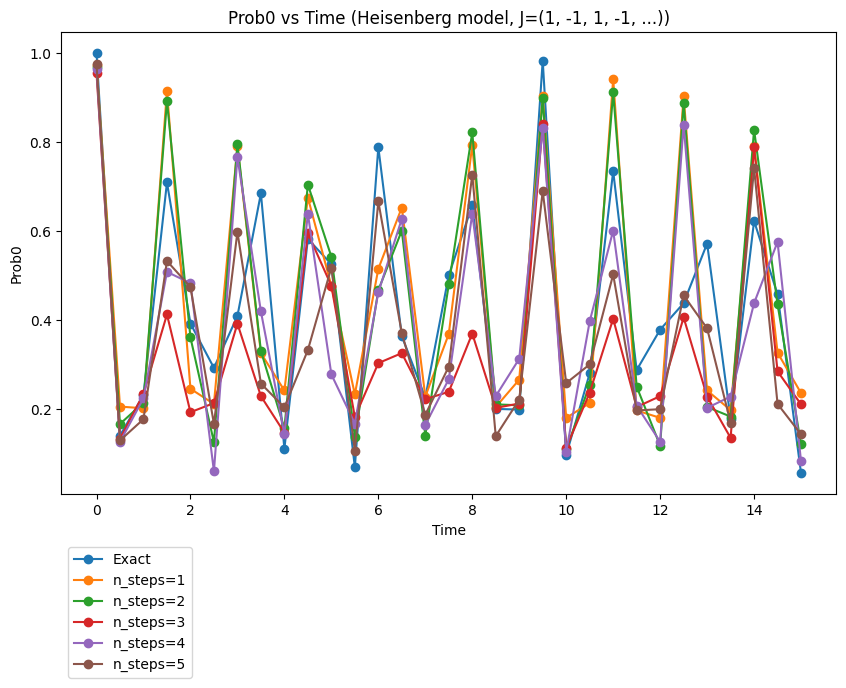

In [12]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(times, prob0s_exact, "o-", label="Exact")
for n_steps in n_steps_range:
    plt.plot(times, prob0s_of_all_n_steps[n_steps], "o-", label=f"n_steps={n_steps}")
plt.title("Prob0 vs Time (Heisenberg model, J=(1, -1, 1, -1, ...))")
plt.xlabel("Time")
plt.ylabel("Prob0")
plt.legend(bbox_to_anchor=(0, -0.1), loc="upper left")
plt.show()